In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import impt
import jax
import fitsio
import numpy as np
import jax.numpy as jnp
from fpfs import pltutil
import astropy.io.ascii as pyascii
import matplotlib.pylab as plt
import pandas as pd

2023-04-30 13:05:58.195426: I external/xla/xla/service/service.cc:168] XLA service 0x55baf02c3f10 initialized for platform Interpreter (this does not guarantee that XLA will be used). Devices:
2023-04-30 13:05:58.199280: I external/xla/xla/service/service.cc:176]   StreamExecutor device (0): Interpreter, <undefined>
2023-04-30 13:05:58.500343: I external/xla/xla/pjrt/tfrt_cpu_pjrt_client.cc:218] TfrtCpuClient created.
2023/04/30 13:05:58 ---  Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/04/30 13:05:58 ---  Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/04/30 13:05:58 ---  Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023/04/30 13:05:58 ---  Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_p

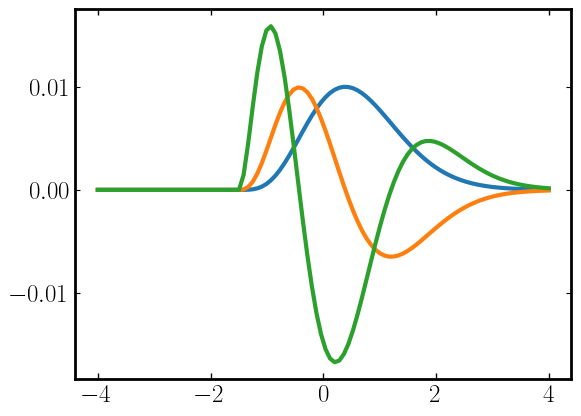

In [2]:
x = jnp.linspace(-4,4,100)
func = lambda a: impt.fpfs.utils.ssfunc3(a, mu = 1., sigma = 2.5) * jnp.exp(-(a+4)**2./6)
dfunc = jax.grad(func)
ddfunc =  jax.grad(dfunc)
dy1 = jax.lax.map(dfunc,x)
y2 = jax.lax.map(func,x)
dy2 = jax.lax.map(dfunc,x)
ddy2 = jax.lax.map(ddfunc,x)


plt.close()
#plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, dy2)
plt.plot(x, ddy2)

(5000, 4, 1)
(5000, 4, 1)
(5000, 4, 1)
(5000, 4, 1)
(5000, 4, 1)
Separate galaxies into 5 bins: [26.5 26.  25.5 25.  24.5]
Multiplicative biases for those bins are:  [ 0.0005665   0.00078702  0.00032659  0.00057403 -0.00049053]
Errors are:  [0.00118081 0.00106583 0.00102812 0.00110947 0.00128084]
Additive biases for those bins are:  [-2.00839797e-05 -1.51247429e-05 -3.83450196e-06  5.73260073e-06
  6.10707256e-06]
Errors are:  [2.12258718e-05 1.80944444e-05 1.58182857e-05 1.45427591e-05
 1.40311570e-05]
         merr        
---------------------
0.0007596272996735466
0.0008288497028317802
0.0009605248685378594
0.0011558380258859047
 0.001439519033534418


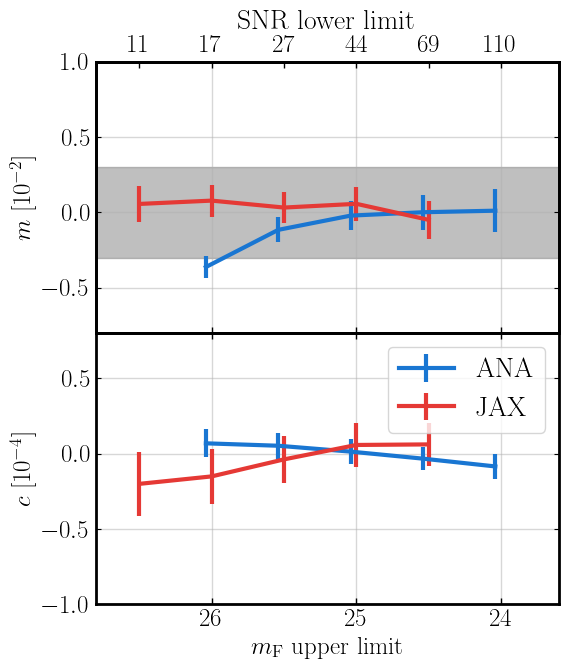

In [14]:
shear_value = 0.02
#maglist = [26.5, 26, 25.5, 25.0, 24.5, 24.]
maglist = [26.5, 26, 25.5, 25.0, 24.5]
res = np.zeros((4, len(maglist)))
err = np.zeros((4, len(maglist)))
nsims = np.zeros(len(maglist))
for im,mm in enumerate(maglist):
    outs=[]
    for ii in range(0,10):
        fname = './sum_n2_basic1/try1_bin_%.1f_run%d.fits' %(mm,ii)
        if os.path.isfile(fname):
            dd = fitsio.read(fname)
            outs.append(dd)
    outs = np.vstack(outs)
    print(outs.shape)
    nsims[im] = outs.shape[0]
    res[:,im] = np.average(outs, axis=0)[:,0]
    err[:,im] = np.std(outs, axis=0)[:,0]
    
mbias = (res[1] / res[3] / 2.0 - shear_value) / shear_value
merr = (err[1] / res[3] / 2.0) / shear_value / np.sqrt(nsims)
cbias = res[2] / res[3]
cerr = err[2] / res[3] / np.sqrt(nsims)

print("Separate galaxies into %d bins: %s" % (len(res[0]), res[0]))
print("Multiplicative biases for those bins are: ", mbias)
print("Errors are: ", merr)
print("Additive biases for those bins are: ", cbias)
print("Errors are: ", cerr)
# make plot
plt.close()
fig,axes= plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,7))
#pltutil.make_figure_axes(ny=2,nx=1,square=False)

# read data
outs = pyascii.read('sum_n2_basic1/try1_bin_M00.csv')
msk = outs['binave']>23.5
x=outs['binave'][msk]
y1=outs['mbias'][msk]
yerr=outs['merr'][msk]
print(yerr)
z1=outs['cbias'][msk]
zerr=outs['cerr'][msk]

ax=axes[0]
xlabel=r'$m_{\rm F}$ upper limit'
ax.errorbar(np.array(x)+0.04,np.array(y1)*1e2,np.array(yerr)*1e2,label='ANA',color=pltutil.colors[1])
ax.errorbar(res[0],mbias*1e2,merr*1e2,color=pltutil.colors[2], label='JAX')

ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(23.6,26.3)
ax.set_ylim(-0.8,1.)

ax.invert_xaxis()
ax.axhspan(-0.3,0.3,0,100,color='gray',alpha=0.5)
ax.grid()
axb = ax.twiny()
axb.set_xlim(23.6,26.8)
axb.set_xticks((26.5, 26, 25.5, 25, 24.5, 24))
axb.set_xticklabels(('11', '17', '27', '44', '69', '110'))
axb.set_xlabel('SNR lower limit')
axb.invert_xaxis()

ax=axes[1]
ax.errorbar(np.array(x)+0.04,np.array(z1)*1e4,np.array(zerr)*1e4, label='ANA',color=pltutil.colors[1])
ax.errorbar(res[0],cbias*1e4,cerr*1e4,color=pltutil.colors[2], label='JAX')
ax.legend()
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(23.6,26.8)
ax.set_ylim(-1,0.8)

ax.set_xlabel(xlabel,fontsize=18)
ax.grid()
ax.invert_xaxis()
fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.show()

(500, 3, 6)
[10.26031001 11.1152583  10.94922082  7.98904778  5.15611162  2.96443646]


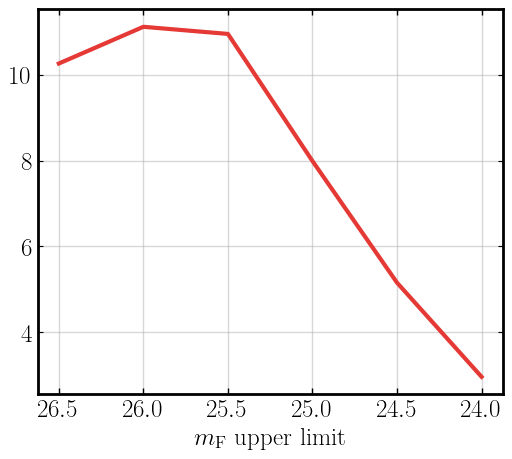

In [58]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=1,nx=1,square=False)


if False:
    ## read data
    outs = pyascii.read('sum_n2_basic1/try1_bin_M00_neff.csv')
    x=outs['binave']
    y=outs['cerr']
    print(y)

    y=(0.26/(np.sqrt((0.2*7100/60/2.)**2.*np.pi)*y))**2.

    ax=axes[0]
    xlabel=r'$m_{\rm F}$ upper limit'
    ax.plot(np.array(x),np.array(y),label=r'$0.5$ arcsec',color=pltutil.colors[1])


outs = []
for ii in range(1):
    fname = './sum_n2_basic1/try1_bin_neff_run%d.fits' %ii
    dd = fitsio.read(fname)
    outs.append(dd)
outs = np.vstack(outs)
print(outs.shape)

res = np.average(outs, axis=0)
err = np.std(outs, axis=0)
    
cerr = err[1] / res[2] 
cerr=(0.26/(np.sqrt((0.2*7100/60/2.)**2.*np.pi)*cerr))**2.
print(cerr)



ax.legend()
ax.set_ylabel('n effective',fontsize=18)
ax.set_xlim(22.6,26.6)

x=res[0]
y=cerr
ax=axes[0]
xlabel=r'$m_{\rm F}$ upper limit'
ax.plot(np.array(x),np.array(y),color=pltutil.colors[2])

ax.set_xlabel(xlabel,fontsize=18)
ax.grid()
ax.invert_xaxis()
plt.show()

In [1]:
a=pyfits.getdata('cat_n2_basic1/cov_matrix.fits')
for imag in [27.5, 26.5,26,25.5,25,24.5, 24.]:
    print(10 ** (( 30.- imag) / 2.5)/np.sqrt(a[0,0]))
    print(10 ** (( 30.- imag) / 2.5))

4.382145006956511
10.0
11.007450583881512
25.118864315095795
17.445633496745927
39.810717055349734
27.649465767164184
63.09573444801933
43.82145006956511
100.0
69.45231789902836
158.48931924611142
110.07450583881513
251.18864315095797


In [6]:
for i in range(31):
    print(np.sqrt(a[i,i]))

2.281987470548174
4.464900630333161
2.955811573304918
2.9557195611009064
7.901541737074535
5.3640191331187035
5.363437387870826
1.4521278023013184
1.452129511484578
1.452127802301318
1.452129511484578
1.4521278023013184
1.452129511484578
1.452127802301318
1.452129511484578
4.164227779036544
4.154821453479522
4.164227779036545
4.154821453479522
4.164227779036544
4.154821453479522
4.164227779036545
4.154821453479522
4.154241491662426
4.163677447583512
4.154241491662426
4.163677447583511
4.154241491662426
4.163677447583512
4.154241491662427
4.163677447583512


In [8]:
1.5/0.6

2.5

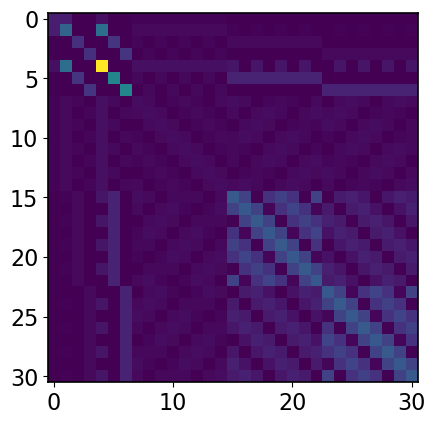

In [52]:
plt.imshow(np.abs(a))